<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Downloads_plus_patches_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [0]:
# install libraries

# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install sentinelsat
!pip install glymur
!pip install python-geotiepoints
!pip install pyspectral
!pip install progressbar2
!pip install kaggle
!pip install tifffile

In [2]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [3]:
# Base dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
import rasterio as rio # raster spatial operations
import json

# Plotting
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import matplotlib.pyplot as plt

#Sentinel-2 I/O
from sentinelsat import SentinelAPI
import requests, zipfile, io, os, shutil # downloading and extracting zipfolders

# Sentinel-2 create patches
from shapely.geometry import Point # vector geometries
import time
import progressbar

# Resize Kaggle patches
from skimage.transform import resize
import tifffile as tiff
import scipy.ndimage

#data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Define Functions

In [0]:
# Extracts RGB 3-channel image from SAFE directory and saves it in the working directory 
# and returns the path to the new file
def extract_rgb_jp2(safePath, sceneTitle):
  for subdirs, dirs, files in os.walk(safePath):
    for file in files:
      if file.endswith('_TCI.jp2'):
        rgbPath = os.path.join(subdirs, file)
        destPath = sceneTitle+'.jp2'
        print(f'Copying {file} to {destPath}')
        shutil.copy2(rgbPath, destPath)
        return destPath

In [0]:
# returns matrix of [n ships, patch_size, patch_size]
def create_ship_patches(ships, img, patch_size=50):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      patch = img.read(window=window) # clip is a nbands * patch_size * patch_size numpy array
      patch_list[i] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
      bar.update(i)
  return patch_list.astype(int)

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# creates patches that correspond to a sample
def create_patches_sample(img, 
                          sample, # the output of `patch_intersects_ship_buffers()`
                          patch_size=50, 
                          step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          # index += 1
          pass
        elif index not in sample.index:
          index += 1
          bar.update(index)
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_buffers(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))
  isShip_list = [] #list to hold all the patch locations
  buffer_list = []
  x_list = []
  y_list = []
  index = 0

  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          #create centroid point
          centroid = Point(img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
          buffer = centroid.buffer(img.transform[0]*step_size/1.5)
          buffer_list.append(buffer)
          isShip = np.any(ships.intersects(buffer)) #intersect ships with polygon and check if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# plots a patch
def plot_patch(img, x, y, patch_size=50, step_size=30):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  show(patch, title=f'x: {x}, y: {y}')

# Define Parameters

In [0]:
DRIVE_PATH = '/content/drive/My Drive/MUSA-650-Final-Project/'

In [0]:
#Load param file
with open(DRIVE_PATH+'params.json', 'r') as file:
    params = json.load(file)
    
    SENTINEL_USER = params['SENTINEL_USER']
    SENTINEL_PWD = params['SENTINEL_PWD']
    KAGGLE_USER = params['KAGGLE_USER']
    KAGGLE_KEY = params['KAGGLE_KEY']

In [0]:
# unique Sentinel-2 tile id for images covering Singapore
TILE_ID = "48NUG" 

In [0]:
# Patch parameters
PATCH_SIZE = 30
STEP_SIZE = 12
SCALE_FACTOR = 3.7/10 #PlanetScope GSD / Sentinel-2 GSD

# Download Data

## Sentinel-2

In [14]:
# Sentinel API Query
api = SentinelAPI(SENTINEL_USER, SENTINEL_PWD, 'https://scihub.copernicus.eu/dhus')

scenes = api.to_geodataframe(api.query(tileid=TILE_ID,
                                             date=('20100101','NOW'),
                                             platformname='Sentinel-2',
                                             cloudcoverpercentage=(0, 6)))
#get full scene metadata
tempList = list()
for uuid in scenes.uuid:
  tempList.append(api.get_product_odata(uuid, full=True))

sceneMeta = pd.DataFrame(tempList)
sceneMeta = sceneMeta.loc[sceneMeta['Online'] == True] # filter out images that are in Long Term Archive and have a 30 minute throttle to download

sceneMeta

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,title,size,md5,date,footprint,url,Online,Creation Date,Ingestion Date,Cloud cover percentage,Datatake sensing start,Date,Degraded ancillary data percentage,Degraded MSI data percentage,Filename,Footprint,Format,Format correctness,General quality,Generation time,Geometric quality,Identifier,Instrument,Instrument abbreviation,Instrument mode,Instrument name,JTS footprint,Mission datatake id,NSSDC identifier,Orbit number (start),Pass direction,Platform serial identifier,Processing baseline,Processing level,Product type,Radiometric quality,Relative orbit (start),Satellite,Satellite name,Satellite number,Sensing start,Sensing stop,Sensor quality,Size,Tile Identifier,Tile Identifier horizontal order,Level-1C PDI Identifier,Datastrip identifier,Granule identifier
0,8345c17f-dd76-4398-b4bf-2eb708631b07,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,784125118,FCD2A37B4A069C5342299AD2AEE90B41,2019-12-27 03:21:31.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-12-27 08:04:08.105,2019-12-27 08:03:15.620,3.6098,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,0.0,0,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-12-27 06:07:36,PASSED,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2A_20191227T032131_023567_N02.08,2015-028A,23567,DESCENDING,Sentinel-2A,2.08,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,A,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,PASSED,747.76 MB,48NUG,NG48U,S2A_OPER_MSI_L1C_TL_EPAE_20191227T060736_A0235...,NaN,NaN
1,5d57f964-03cb-4001-a2f2-33f9eba9605e,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,779449455,5E51BCC8A45CF3ADD026433463D37D58,2019-07-05 03:15:49.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-07-05 10:32:33.443,2019-07-05 09:41:20.667,5.5518,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,0.0,0,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-07-05 06:53:23,PASSED,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2B_20190705T031549_012156_N02.07,2017-013A,12156,DESCENDING,Sentinel-2B,2.07,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,B,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,PASSED,743.30 MB,48NUG,NG48U,S2B_OPER_MSI_L1C_TL_SGS__20190705T065323_A0121...,NaN,NaN


In [15]:
# download sentinel images available online
for index, row in sceneMeta.iterrows():
  uuid = row['id']
  title = row['title']
  filename = row['Filename']
  print(f'Downloading {title}')
  api.download(uuid)

Downloading: 100%|██████████| 784M/784M [00:41<00:00, 18.9MB/s]
MD5 checksumming: 100%|██████████| 784M/784M [00:01<00:00, 430MB/s]


Downloading: 100%|██████████| 779M/779M [00:29<00:00, 26.3MB/s]
MD5 checksumming: 100%|██████████| 779M/779M [00:01<00:00, 426MB/s]


In [16]:
# Unzip folders
# this creates SAFE files/directories which are explained here: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats
for index, row in sceneMeta.iterrows(): 
    title = row['title']
    filename = row['Filename']
    print(f'Unzipping {title}')
    with zipfile.ZipFile(title+'.zip', 'r') as safezip:
      safezip.extractall(filename)

Unzipping S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736
Unzipping S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323


In [17]:
image_paths = []
for index, row in sceneMeta.iterrows():
  image_paths.append(extract_rgb_jp2(row['Filename'], row['title']))
print(image_paths)

Copying T48NUG_20191227T032131_TCI.jp2 to S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2
Copying T48NUG_20190705T031549_TCI.jp2 to S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2
['S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2', 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2']


In [18]:
# delete unneeded files to free up space
# eventually maybe move into extraction for-loops
for name in sceneMeta.title:
  if os.path.exists(name+'.zip'):
    print(f'Deleting {name}.zip')
    os.remove(name+'.zip')
  if os.path.exists(name+'.SAFE'):
    print(f'Deleting {name}.SAFE')
    shutil.rmtree(name+'.SAFE')

Deleting S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.zip
Deleting S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.SAFE
Deleting S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.zip
Deleting S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.SAFE


In [19]:
os.listdir()

['.config',
 'shipsnet.json',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2',
 'shipsnet',
 '.kaggle',
 'ships-in-satellite-imagery.zip',
 'scenes',
 'drive',
 'sample_data']

## Kaggle PlanetScope

In [20]:
os.mkdir('.kaggle')
os.listdir()

FileExistsError: ignored

In [0]:
token = {"username":KAGGLE_USER,"key":KAGGLE_KEY}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [22]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}
- path is now set to: {/content}


In [23]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

ships-in-satellite-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
os.listdir()

['.config',
 'shipsnet.json',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2',
 'shipsnet',
 '.kaggle',
 'ships-in-satellite-imagery.zip',
 'scenes',
 'drive',
 'sample_data']

In [0]:
with zipfile.ZipFile('ships-in-satellite-imagery.zip', 'r') as kaggleZip:
      kaggleZip.extractall(os.getcwd())

In [26]:
with open('shipsnet.json') as data_file:
    kg_ships_dict = json.load(data_file)
kg_ships_df = pd.DataFrame(kg_ships_dict)
print(kg_ships_df.shape)
kg_ships_df.head()

(4000, 4)


,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [27]:
n_spectrum = 3 # color channel (RGB)
kg_patch_size = 80
kg_ships_patches = np.array(kg_ships_dict['data']
             ).astype('uint8'
             ).reshape([-1, n_spectrum, kg_patch_size, kg_patch_size])
kg_ships_patches = np.moveaxis(kg_ships_patches, 1, 3)
kg_ships_patches.shape

(4000, 80, 80, 3)

In [28]:
kg_ships_patches.min(), kg_ships_patches.max()

(1, 255)

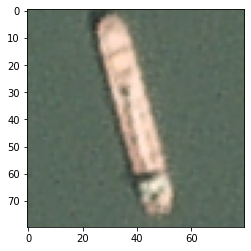

In [29]:
plt.imshow(kg_ships_patches[100]);

Resize patches so each pixel has a 10m resolution.

In [0]:
kg_patch_new_size = round(kg_patch_size*SCALE_FACTOR)

kg_patches_resize = np.zeros([kg_ships_patches.shape[0],
                            kg_patch_new_size,
                            kg_patch_new_size,
                            kg_ships_patches.shape[3]])

In [0]:
for img in range(kg_ships_patches.shape[0]):
  kg_patches_resize[img] = resize(kg_ships_patches[img], [kg_patch_new_size, kg_patch_new_size])

(4000, 30, 30, 3)


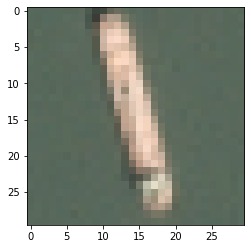

In [32]:
print(kg_patches_resize.shape)
plt.imshow(kg_patches_resize[100]);

# Create Sentinel-2 Patches

In [0]:
# load ship points and scene
scene_name = sceneMeta.title[0] # 
ship_points = gpd.read_file(DRIVE_PATH+scene_name+'_SHIPS.geojson')
sat_img = rio.open(scene_name+'.jp2')

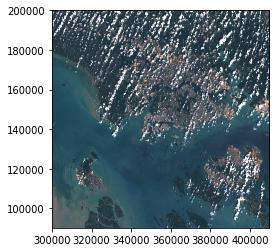

(3, <matplotlib.axes._subplots.AxesSubplot at 0x7f5d2ac96e10>)

In [47]:
print(sat_img.count)
show(sat_img);

Create dataframe classifying every patch as ship or no ship

In [58]:
csv_path = DRIVE_PATH + 'sentinel_patch_classes.csv'

# sentinel_patch_classes = patch_intersects_ship_buffers(ships = ship_points, 
#                                                        img=sat_img, 
#                                                        patch_size=PATCH_SIZE, 
#                                                        step_size=STEP_SIZE)
# sentinel_patch_classes.to_csv(csv_path, index = False)

sentinel_patch_classes = pd.read_csv(csv_path)

100% (837225 of 837225) |################| Elapsed Time: 0:29:25 Time:  0:29:25


In [73]:
sentinel_patch_classes.groupby('isShip')['isShip'].count()

isShip
False    832972
True        597
Name: isShip, dtype: int64

Create a sample of the patches stratified by isShip

In [0]:
frac = 0.1

sentinel_sample = (sentinel_patch_classes
                   .groupby('isShip', # stratify by isShip
                            group_keys = False)
                   .apply(lambda x: x.sample(frac = frac, # sample by group
                                             random_state = 123))
                   .sort_index()) # the index needs to be sorted for the sample patches to "line up" with `sentinel_sample`

In [238]:
sentinel_sample.groupby('isShip')['isShip'].count()

isShip
False    83297
True        60
Name: isShip, dtype: int64

In [239]:
sentinel_sample.head()

,isShip,x,y,patch_size
17,False,204,0,30
19,False,228,0,30
24,False,288,0,30
28,False,336,0,30
51,False,612,0,30


Create the patches that correspond to the sample index

In [245]:
sentinel_sample_patches = create_patches_sample(img=sat_img, 
                      sample=sentinel_sample,
                      patch_size=PATCH_SIZE, 
                      step_size=STEP_SIZE)

100% (837225 of 837225) |################| Elapsed Time: 0:00:09 Time:  0:00:09


In [246]:
sentinel_sample_patches.shape

(83357, 30, 30, 3)

In [247]:
sentinel_sample.loc[sentinel_sample['isShip'] == True].head()

,isShip,x,y,patch_size
338654,True,10128,4440,30
354255,True,132,4656,30
355235,True,936,4668,30
414435,True,10152,5436,30
425330,True,9420,5580,30


In [250]:
print(np.where(sentinel_sample.index == 354255)[0])

[35420]


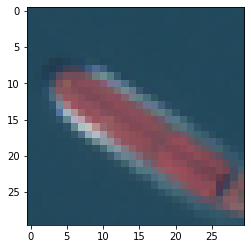

In [251]:
plt.imshow(sentinel_sample_patches[35420]);

In [39]:
## we would use this to create every patch
## but it's too many to fit in memory

# sentinel_patches = create_patches(img=sat_img, 
#                                   patch_size=PATCH_SIZE, 
#                                   step_size=STEP_SIZE)

100% (21609 of 21609) |##################| Elapsed Time: 0:00:38 Time:  0:00:38


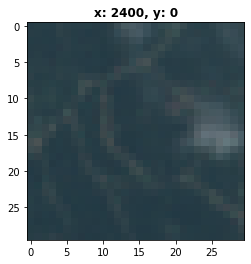

In [252]:
plot_patch(img=sat_img,
           x=sentinel_patch_classes.x[200],
           y=sentinel_patch_classes.y[200],
           patch_size=PATCH_SIZE, 
           step_size=STEP_SIZE)

Create array with labels for sample patches

In [269]:
lb = LabelEncoder()
sentinel_sample_labels = lb.fit_transform(sentinel_sample['isShip'])

(array([0, 1]), array([83297,    60]))

# Prepare Data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(kg_patches_resize, 
                                                    kg_ships_df.labels, 
                                                    stratify=kg_ships_df.labels, 
                                                    test_size=0.5, 
                                                    random_state=42)
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

In [0]:
datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True)

In [0]:
datagen.fit(x_train)

In [0]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs)